# ***Alireza Bolhassani***
---

## Data Reading and Initial Processing

the groundtruth data and participants consisit of 2909 row

In [116]:
# Read the dataframe in pandas format
import pandas as pd

groundtruth = pd.read_csv("groundtruth.tsv", delimiter="\t")
groundtruth = groundtruth.drop(["attention","user_id"], axis=1)
groundtruth.head(3) 

,ad_clicked,log_id
0,0,20181002033126
1,1,20181001211223
2,0,20181001170952


In [117]:
participants = pd.read_csv("participants.tsv", delimiter="\t")
participants = participants.drop(["user_id","education","age","income","gender"], axis=1)
participants.head(3)

,country,ad_position,ad_type,ad_category,serp_id,query,log_id
0,PHL,top-left,dd,Computers & Electronics,tablets,tablets,20181002033126
1,VEN,top-right,dd,Shop - Luxury Goods,casio-watches,casio watches,20181001211223
2,VEN,top-left,native,Shop - Luxury Goods,chivas-regal,chivas regal,20181001170952


---
## Merge two data frame

In [118]:
df = participants.merge(groundtruth,on="log_id")
df["log_id"] = df["log_id"].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      2909 non-null   object
 1   ad_position  2909 non-null   object
 2   ad_type      2909 non-null   object
 3   ad_category  2909 non-null   object
 4   serp_id      2909 non-null   object
 5   query        2909 non-null   object
 6   log_id       2909 non-null   object
 7   ad_clicked   2909 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 181.9+ KB


In [119]:
import numpy as np
# Extract the column names with number type
num_columns = df.select_dtypes(np.number).columns.to_list()

# Extract the column names with object type
object_columns = df.select_dtypes(object).columns.to_list()

# print the result
print(f'columns that have numercal types are =>{num_columns} \n\
columns that have object types are =>{object_columns}')

columns that have numercal types are =>['ad_clicked'] 
columns that have object types are =>['country', 'ad_position', 'ad_type', 'ad_category', 'serp_id', 'query', 'log_id']


---
## Filter data frame based on time spent

In [120]:
import os
df["time_spent"] = 0

for index,row in df.iterrows():
    file_path = f"logs/{row['log_id']}.csv"
    if not os.path.exists(file_path):
        continue
    df2 = pd.read_csv(file_path, delimiter=" ")
    time_spent = df2["timestamp"].iloc[-1] - df2["timestamp"].iloc[0]
    df.at[index,"time_spent"] = int(time_spent/1000)

df = df[df["time_spent"] > 5]
df.head(3)

,country,ad_position,ad_type,ad_category,serp_id,query,log_id,ad_clicked,time_spent
0,PHL,top-left,dd,Computers & Electronics,tablets,tablets,20181002033126,0,96
1,VEN,top-right,dd,Shop - Luxury Goods,casio-watches,casio watches,20181001211223,1,18
2,VEN,top-left,native,Shop - Luxury Goods,chivas-regal,chivas regal,20181001170952,0,54


---
## Convert categorical values to numeral values

In [121]:
categories = ["query","country","ad_type","ad_position","ad_category","serp_id"]

for cat_name in categories:
    names = df[cat_name].unique()
    nums =[i for i in range(len(names))]
    df[cat_name] = df[cat_name].replace(names,nums)

In [122]:
# Count number of values under ad_type
print(df['ad_type'].value_counts())
print("------")
print(df['ad_position'].value_counts())

ad_type
0    1612
1     806
Name: count, dtype: int64
------
ad_position
0    1640
1     778
Name: count, dtype: int64


---
## Check null values

In [123]:
# Count the number of null values in each feature
num_null_value = df.isnull().sum()

# Determine the number of unique values in each feature
num_unique_value = df.nunique()

# Create a summary dataframe combining null and unique value counts
df_summary = pd.concat([num_null_value,num_unique_value], axis='columns', 
                       keys= ['num of nulls', 'num of unique'])
df_summary

,num of nulls,num of unique
country,0,68
ad_position,0,2
ad_type,0,2
ad_category,0,14
serp_id,0,63
query,0,55
log_id,0,2418
ad_clicked,0,2
time_spent,0,276


----
## Extract xml data consisit document width and height

In [127]:
# pip install beautifulsoup4
from bs4 import BeautifulSoup

df["doc_width"] = 0
df["doc_height"] = 0

for index,row in df.iterrows():
    with open(f"logs/{row['log_id']}.xml", 'r') as f:
        data = f.read()
    doc_w, doc_h = BeautifulSoup(data, "xml").find("document").text.split("x")
    scr_w, scr_h = BeautifulSoup(data, "xml").find("screen").text.split("x")
    df.at[index,"doc_width"] = max(int(doc_w),int(scr_w))
    df.at[index,"doc_height"] = max(int(doc_h),int(scr_h))


----
## Extract log file information into matrix

In [129]:

event = {"click":1,"mouseup":2,"mouseover":3,"mousedown":4,"mousemove":5}
w = 3
h = 3
matrix1 = []
matrix2 = []

for index1,row1 in df.iterrows():

    matrix_event = np.array([[0 for x in range(w)] for y in range(h)])
    matrix_time = np.array([[0 for x in range(w)] for y in range(h)])

    df2 = pd.read_csv(f"logs/{row1['log_id']}.csv", delimiter=" ")
    start_time = df2.at[0,"timestamp"]

    for index, row in df2.iterrows():
        xpos = (int(row["xpos"])/row1["doc_width"]) * w
        xpos = min(w-1,int(xpos))

        ypos = (int(row["ypos"])/row1["doc_height"]) * h
        ypos = min(h-1,int(ypos))

        matrix_event[xpos][ypos] = event.get(row["event"]) or 0
        matrix_time[xpos][ypos] = int((row["timestamp"] - start_time)/1000)


    matrix_event = matrix_event.flatten()
    matrix1.append(matrix_event)

    matrix_time = matrix_time.flatten()
    matrix2.append(matrix_time)    

matrix1 = pd.DataFrame(matrix1)
matrix2 = pd.DataFrame(matrix2)

matrix1 =  matrix1.astype(int)
matrix2 =  matrix2.astype(int)

dataset = pd.concat([df, matrix1, matrix2], axis=1)

----

In [130]:
labels = dataset["ad_clicked"]
dataset = dataset.drop("ad_clicked", axis=1)

print(f'Shape of features data set for ML models => {dataset.shape}')
print(f'Shape of target for ML models => {labels.shape}')

Shape of features data set for ML models => (2822, 28)
Shape of target for ML models => (2822,)


,country,ad_position,ad_type,ad_category,serp_id,query,time_spent
country,1.000000,-0.012228,0.021801,-0.031461,0.020869,0.021812,-0.007363
ad_position,-0.012228,1.000000,-0.487027,-0.038127,-0.097111,-0.081319,-0.014017
ad_type,0.021801,-0.487027,1.000000,0.129545,0.101517,0.143896,0.028772
ad_category,-0.031461,-0.038127,0.129545,1.000000,0.127623,0.083719,0.023210
serp_id,0.020869,-0.097111,0.101517,0.127623,1.000000,0.948300,0.000507
query,0.021812,-0.081319,0.143896,0.083719,0.948300,1.000000,0.004434
time_spent,-0.007363,-0.014017,0.028772,0.023210,0.000507,0.004434,1.000000


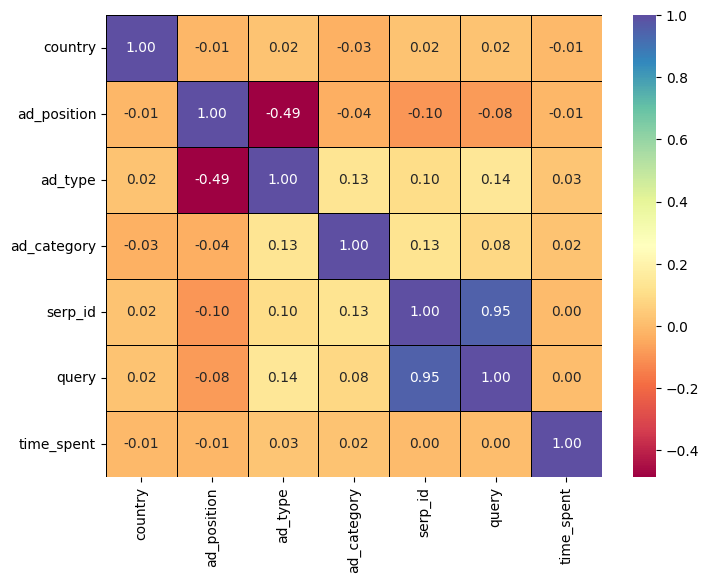

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create correlation matrix for features
features = dataset[["country","ad_position","ad_type","ad_category","serp_id","query","time_spent"]]
feature_corr = features.corr(numeric_only=True)

# Display correlation matrix
display(feature_corr)

# Plot correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(feature_corr, annot=True, fmt='0.2f', linewidths=0.5, linecolor='Black', cmap='Spectral')
plt.show()

----

In [132]:
from sklearn.model_selection import train_test_split

X_trainvald, X_test, y_trainvald, y_test = train_test_split(dataset, labels, test_size=0.20, random_state=42)
X_train, X_vald, y_train, y_vald = train_test_split(X_trainvald, y_trainvald, test_size=0.25, random_state=42)

In [133]:
dataset.shape
dataset.to_string("text.txt")

----
## Create Convolutional Neural Network Model

In [106]:
from tensorflow.keras import layers, models, regularizers

input_tensor = layers.Input(shape=(2822,29, 3))

################### Conv layer one #######################
conv1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(input_tensor)
maxpool1 = layers.MaxPooling2D((2, 2))(conv1)
dropout1 = layers.Dropout(0.25)(maxpool1)

################### Conv layer two #######################
conv2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(dropout1)
maxpool2 = layers.MaxPooling2D((2, 2))(conv2)
dropout2 = layers.Dropout(0.25)(maxpool2)

conv3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01))(dropout2)
maxpool3 = layers.MaxPooling2D((2, 2))(conv3)

################### Convert tensors to vectors #######################
flatten = layers.Flatten()(maxpool3)

dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01))(flatten)
dropout3 = layers.Dropout(0.5)(dense1)

n_classes = len(np.unique(labels)) 
output_tensor = layers.Dense(n_classes, activation='sigmoid')(dropout3)
modeling = models.Model(inputs=input_tensor, outputs=output_tensor)

In [107]:
modeling.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [108]:
from tensorflow.keras.callbacks import ModelCheckpoint

checking = ModelCheckpoint('my_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [109]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [110]:
epochs = 100
batch_size = 64
history = modeling.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_vald, y_vald), callbacks=[early_stop, checking])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

----
## References

- Keras API reference / Optimizers(https://keras.io/api/optimizers/)